### Código em Python para detecção de fraude em anúncios de celulares na OLX


#### Etapa 1

Adquirindo um arquivo CSV com os dados

In [20]:
from sklearn import preprocessing
import pandas as pd
import joblib

# Abrir a base de dados
tabela = pd.read_csv('train.csv')
display(tabela)


,Marca,Modelo,Condicao,Memoria,Bateria,Preco,TempoConta,Vendas,Golpe
0,Apple,iPhone 10,Usado - Bom,32,Ruim (40% ate 59%),285.51,327,2,Sim
1,Apple,iPhone 14,Recondicionado,512,Ok (60% ate 79%),3595.91,125,4,Nao
2,Apple,iPhone 11,Com defeito,64,Muito Ruim (abaixo de 39%),4048.08,79,13,Sim
3,Apple,iPhone 13,Usado - Bom,256,Ruim (40% ate 59%),568.90,133,4,Sim
4,Apple,iPhone 14,Com defeito,256,Perfeita (95% ate 100%),2195.17,276,15,Nao
...,...,...,...,...,...,...,...,...,...
199995,Apple,iPhone 14,Usado - Excelente,512,Ruim (40% ate 59%),1261.18,236,16,Sim
199996,Apple,iPhone 14,Recondicionado,512,Perfeita (95% ate 100%),1494.21,218,19,Sim
199997,Apple,iPhone XR,Novo,32,Perfeita (95% ate 100%),3186.79,243,16,Sim
199998,Apple,iPhone 14,Com defeito,256,Muito Ruim (abaixo de 39%),1143.17,316,10,Sim


#### Etapa 2

Codificando os dados em uma matriz de números inteiros, que irão ser utilizados nos algoritmos de classificação

In [21]:

enc = preprocessing.OrdinalEncoder()

codes = enc.fit(tabela[["Marca", "Modelo", "Condicao", "Bateria", "Golpe"]])
joblib.dump(codes, "../services/preprocessorCodes.joblib")

transformedData = codes.transform(tabela[["Marca", "Modelo", "Condicao", "Bateria", "Golpe"]])

resultData = pd.DataFrame(
    {
        "Marca": transformedData[:, 0],
        "Modelo": transformedData[:, 1],
        "Condicao": transformedData[:, 2],
        "Memoria": tabela["Memoria"],
        "Bateria": transformedData[:, 3],
        "Preco": tabela["Preco"],
        "TempoConta": tabela["TempoConta"],
        "Vendas": tabela["Vendas"],	
        "Golpe": transformedData[:, 4]
    }
)


#### Continuação - Etapa 2

Mostrando os dados transformados

        Marca  Modelo  Condicao  Memoria  Bateria    Preco  TempoConta  \
0         0.0     0.0       3.0       32      4.0   285.51         327   
1         0.0     4.0       2.0      512      2.0  3595.91         125   
2         0.0     1.0       0.0       64      1.0  4048.08          79   
3         0.0     3.0       3.0      256      4.0   568.90         133   
4         0.0     4.0       0.0      256      3.0  2195.17         276   
...       ...     ...       ...      ...      ...      ...         ...   
199995    0.0     4.0       4.0      512      4.0  1261.18         236   
199996    0.0     4.0       2.0      512      3.0  1494.21         218   
199997    0.0     7.0       1.0       32      3.0  3186.79         243   
199998    0.0     4.0       0.0      256      1.0  1143.17         316   
199999    0.0     0.0       0.0      128      4.0  1992.51         168   

        Vendas  Golpe  
0            2    1.0  
1            4    0.0  
2           13    1.0  
3            4 

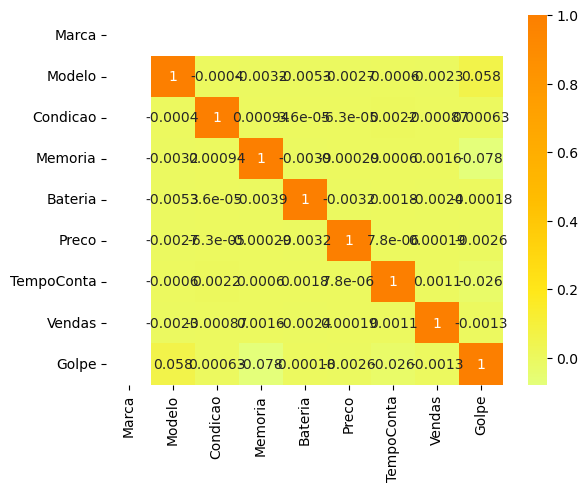

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

print(resultData)

# Análise preliminar
sns.heatmap(resultData.corr(), annot=True, cmap="Wistia")
plt.show()

#### Etapa 3

Criando um conjunto de teste e um de validação, usando a base de dados original.

In [23]:
# Machine learning
from sklearn.model_selection import train_test_split

# Dividir a base de dados em x e y de treino e de teste
y = resultData["Golpe"]
x = resultData[["Marca", "Modelo", "Condicao", "Memoria","Bateria", "Preco", "TempoConta", "Vendas"]]


x_treino, x_teste, y_treino, y_teste = train_test_split(x, y)

#### Etapa 4

Usando os algoritmos de Regressão Linear e de Randon Forest para aprender os padrões dos dados utilizados

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn import metrics

# Criar os dois modelos de IAs
modelo_RegressãoLinear = LinearRegression()
modelo_RandomForest = RandomForestRegressor()
modelo_AdaBoost = AdaBoostRegressor()

# Treinar as duas IAs com o x e y de treino
modelo_RegressãoLinear.fit(x_treino, y_treino)
modelo_RandomForest.fit(x_treino, y_treino)
modelo_AdaBoost.fit(x_treino, y_treino)

joblib.dump(modelo_RandomForest, "../services/randomForest.joblib")

# Testar as duas IAs e ver qual tem melhor desempenho no indice R²
previsao_RegressãoLinear = modelo_RegressãoLinear.predict(x_teste)
previsao_RandomForest = modelo_RandomForest.predict(x_teste)
previsao_AdaBoost = modelo_AdaBoost.predict(x_teste)

print(f'R² da Regressão Linear: {metrics.r2_score(y_teste, previsao_RegressãoLinear)}')
print(f'R² da Random Forest: {metrics.r2_score(y_teste, previsao_RandomForest)}') # Maior R² é RandomForest
print(f'R² da Ada Boost: {metrics.r2_score(y_teste, previsao_AdaBoost)}')

R² da Regressão Linear: 0.008036958120438031
R² da Random Forest: 0.9997484818801029
R² da Ada Boost: 0.19911372913894088


In [25]:
# Usar o modelo para prever novos dados
tabela_previsao = pd.read_csv('test.csv')

transformedData2 = codes.transform(tabela_previsao[["Marca", "Modelo", "Condicao", "Bateria", "Golpe"]])
resultData2 = pd.DataFrame(
    {
        "Marca": transformedData2[:, 0],
        "Modelo": transformedData2[:, 1],
        "Condicao": transformedData2[:, 2],
        "Memoria": tabela_previsao["Memoria"],
        "Bateria": transformedData2[:, 3],
        "Preco": tabela_previsao["Preco"],
        "TempoConta": tabela_previsao["TempoConta"],
        "Vendas": tabela_previsao["Vendas"],	
        "Golpe": transformedData2[:, 4]
    }
)

tabela_previsao['Golpe'] = modelo_RandomForest.predict(resultData2[["Marca", "Modelo", "Condicao", "Memoria","Bateria", "Preco", "TempoConta", "Vendas"]])
display(tabela_previsao)


,Marca,Modelo,Condicao,Memoria,Bateria,Preco,TempoConta,Vendas,Golpe
0,Apple,iPhone 8 Plus,Recondicionado,128,Ruim (40% ate 59%),200,13,2,1.0
